In [1]:
import os
import glob
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from llava.constants import IMAGE_TOKEN_INDEX
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, tokenizer_image_token

/home/chengzhang/anaconda3/envs/minigpt4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-10-25 05:50:14,484] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
model_base = None  # "/home/chengzhang/models/llava/llava-v1-0719-336px-lora-merge-vicuna-13b-v1.3"
model_path = "/home/chengzhang/models/llava/llava-v1.5-7b"  # "/home/chengzhang/models/llava/llava-336px-pretrain-vicuna-13b-v1.3"
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, model_base, model_name
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


In [3]:
linear_modules: dict[str, torch.nn.Linear] = {}

for i, layer in enumerate(model.model.layers):
    linear_modules[f'llama/{i}-q-proj'] = layer.self_attn.q_proj
    linear_modules[f'llama/{i}-k-proj'] = layer.self_attn.k_proj
    linear_modules[f'llama/{i}-v-proj'] = layer.self_attn.v_proj
    linear_modules[f'llama/{i}-o-proj'] = layer.self_attn.o_proj
    linear_modules[f'llama/{i}-gate-proj'] = layer.mlp.gate_proj
    linear_modules[f'llama/{i}-down-proj'] = layer.mlp.down_proj
    linear_modules[f'llama/{i}-up-proj'] = layer.mlp.up_proj

for name, module in linear_modules.items():
    module.unique_name = name

ln_modules: dict[str, torch.nn.Linear] = {}

for i, layer in enumerate(model.model.layers):
    ln_modules[f'llama/{i}-input-ln'] = layer.input_layernorm
    ln_modules[f'llama/{i}-post-attn-ln'] = layer.post_attention_layernorm

for name, module in ln_modules.items():
    module.unique_name = name

In [4]:
with open('/home/chengzhang/datasets/OK-VQA/question/OpenEnded_mscoco_val2014_questions.json') as f:
    questions = json.loads(f.read())['questions']

hooks = []

In [5]:
SNAPSHOT_PATH = '/home/chengzhang/Multimodal-Quantization/LLaVA/snapshot'

In [13]:
q = questions[0]
question = q['question']
image_id = q['image_id']
question_id = q['question_id']
image = Image.open(f'/home/chengzhang/datasets/OK-VQA/images/val2014/COCO_val2014_{str(image_id).zfill(12)}.jpg')
image = image_processor.preprocess(image.convert("RGB"), return_tensors='pt')['pixel_values']
image = image.unsqueeze(0).to(torch.float16).to('cuda')

# text = '<image> ' + question
text = f'<image> Question: {question} Brief answer:'
input_ids = tokenizer_image_token(text, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

output_ids = model.generate(
    input_ids,
    images=image,
    do_sample=False,
    # temperature=0.0,
    # min_length=min_generation_length,
    max_new_tokens=50,
    # num_beams=num_beams,
    # length_penalty=length_penalty,
    use_cache=True,
    # stopping_criteria=self.stopping_criteria,
)
tokenizer.decode(output_ids[0][len(input_ids[0]):])

" Motorcycle racing\n\n\nQuestion: What is the motorcycle's color? Brief answer: Black</s>"

In [14]:
question

'What sport can you use this for?'

In [10]:
len(input_ids[0])

17

In [11]:
len(output_ids[0])

40

In [15]:
def save_activations(hooks):

    for i in range(100):

        q = questions[i]
        question = q['question']
        image_id = q['image_id']
        question_id = q['question_id']
        image = Image.open(f'/home/chengzhang/datasets/OK-VQA/images/val2014/COCO_val2014_{str(image_id).zfill(12)}.jpg')
        image = image_processor.preprocess(image.convert("RGB"), return_tensors='pt')['pixel_values']
        image = image.unsqueeze(0).to(torch.float16).to('cuda')

        # text = '<image> ' + question
        text = f'<image> Question: {question} answer:'
        input_ids = tokenizer_image_token(text, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

        # act_folder = f'{SNAPSHOT_PATH}/activations/{question_id}'
        act_folder = f'{SNAPSHOT_PATH}/activations-gen-long/{question_id}'
        os.makedirs(f'{act_folder}/vit', exist_ok=True)
        os.makedirs(f'{act_folder}/q-former', exist_ok=True)
        os.makedirs(f'{act_folder}/llama', exist_ok=True)

        for hook in hooks:
            hook.remove()
        hooks = []

        # def hook(m, input, output):
        #     torch.save(input, f'{act_folder}/{m.unique_name}.pt')

        cache = {}

        def hook(m, input, output):
            # print(f'[{m.unique_name}] {len(input)} {input[0].shape}')
            if input[0].shape[1] == 1:
                if m.unique_name in cache:
                    cache[m.unique_name] = torch.concat((cache[m.unique_name], input[0]), 1)
                else:
                    cache[m.unique_name] = input[0]

        for name, module in linear_modules.items():
            hooks.append(module.register_forward_hook(hook))

        for name, module in ln_modules.items():
            hooks.append(module.register_forward_hook(hook))

        # model(input_ids=input_ids, images=image)
        print(f'\n ########## {i} ##########')
        model.generate(
            input_ids,
            images=image,
            do_sample=False,
            # temperature=0.0,
            # min_length=min_generation_length,
            max_new_tokens=50,
            # num_beams=num_beams,
            # length_penalty=length_penalty,
            use_cache=True,
            # stopping_criteria=self.stopping_criteria,
        )

        for name, val in cache.items():
            # print(name, val.shape)
            torch.save((val, ), f'{act_folder}/{name}.pt')

save_activations(hooks)


 ########## 0 ##########



 ########## 1 ##########

 ########## 2 ##########

 ########## 3 ##########

 ########## 4 ##########

 ########## 5 ##########

 ########## 6 ##########

 ########## 7 ##########

 ########## 8 ##########

 ########## 9 ##########

 ########## 10 ##########

 ########## 11 ##########

 ########## 12 ##########

 ########## 13 ##########

 ########## 14 ##########

 ########## 15 ##########

 ########## 16 ##########

 ########## 17 ##########

 ########## 18 ##########

 ########## 19 ##########

 ########## 20 ##########

 ########## 21 ##########

 ########## 22 ##########

 ########## 23 ##########

 ########## 24 ##########

 ########## 25 ##########

 ########## 26 ##########

 ########## 27 ##########

 ########## 28 ##########

 ########## 29 ##########

 ########## 30 ##########

 ########## 31 ##########

 ########## 32 ##########

 ########## 33 ##########

 ########## 34 ##########

 ########## 35 ##########

 ########## 36 ##########

 ########## 37 ##########

 ########

In [7]:
def plot_activations(ax: plt.Axes, model_name: str, component: str, text_only: str = False):
    snapshot_prefix = 'activations'
    if text_only:
        snapshot_prefix = 'text-' + snapshot_prefix
        title = 'activations (text only)'
    else:
        title = 'activations'
    paths = glob.glob(f'{SNAPSHOT_PATH}/{snapshot_prefix}/*/{model_name}/*-{component}')
    groups: dict[int, list] = {}
    for path in paths:
        file_name = os.path.split(path)[-1]
        idx = int(file_name.split('-')[0])
        if not idx in groups:
            groups[idx] = []
        groups[idx].append(path)
    layers = []
    for idx in sorted(list(groups.keys())):
        shots = np.array([])
        for path in groups[idx]:
            shot = torch.load(path)[0].detach().abs().max(axis=-1).values.flatten().cpu().numpy()
            shots = np.concatenate([shots, shot])
        layers.append(shots)
    ax.boxplot(layers)
    ax.tick_params(axis='x', rotation=60)
    ax.set_xlabel('layer')
    ax.set_ylabel('max abs value of each token')
    ax.set_title(f'[{model_name}] ' + component.split('.')[0] + f': {title}')

In [8]:
def plot_weights(ax: plt.Axes, model_name: str, component: str):
    layers = []
    for i, layer in enumerate(model.model.layers):
        weight = linear_modules[f'llama/{i}-' + component.split('.')[0]].weight.detach().flatten().cpu().numpy()
        layers.append(weight)
    ax.boxplot(layers)
    ax.tick_params(axis='x', rotation=60)
    ax.set_xlabel('layer')
    # ax.set_ylabel('max abs value of each row')
    ax.set_ylabel('abs value')
    ax.set_title(component.split('.')[0] + ': weights')

q-proj.pt: weights


q-proj.pt: activations
k-proj.pt: weights
k-proj.pt: activations
v-proj.pt: weights
v-proj.pt: activations
o-proj.pt: weights
o-proj.pt: activations
gate-proj.pt: weights
gate-proj.pt: activations
up-proj.pt: weights
up-proj.pt: activations
down-proj.pt: weights
down-proj.pt: activations


Text(0.5, 0.98, 'LLAMA')

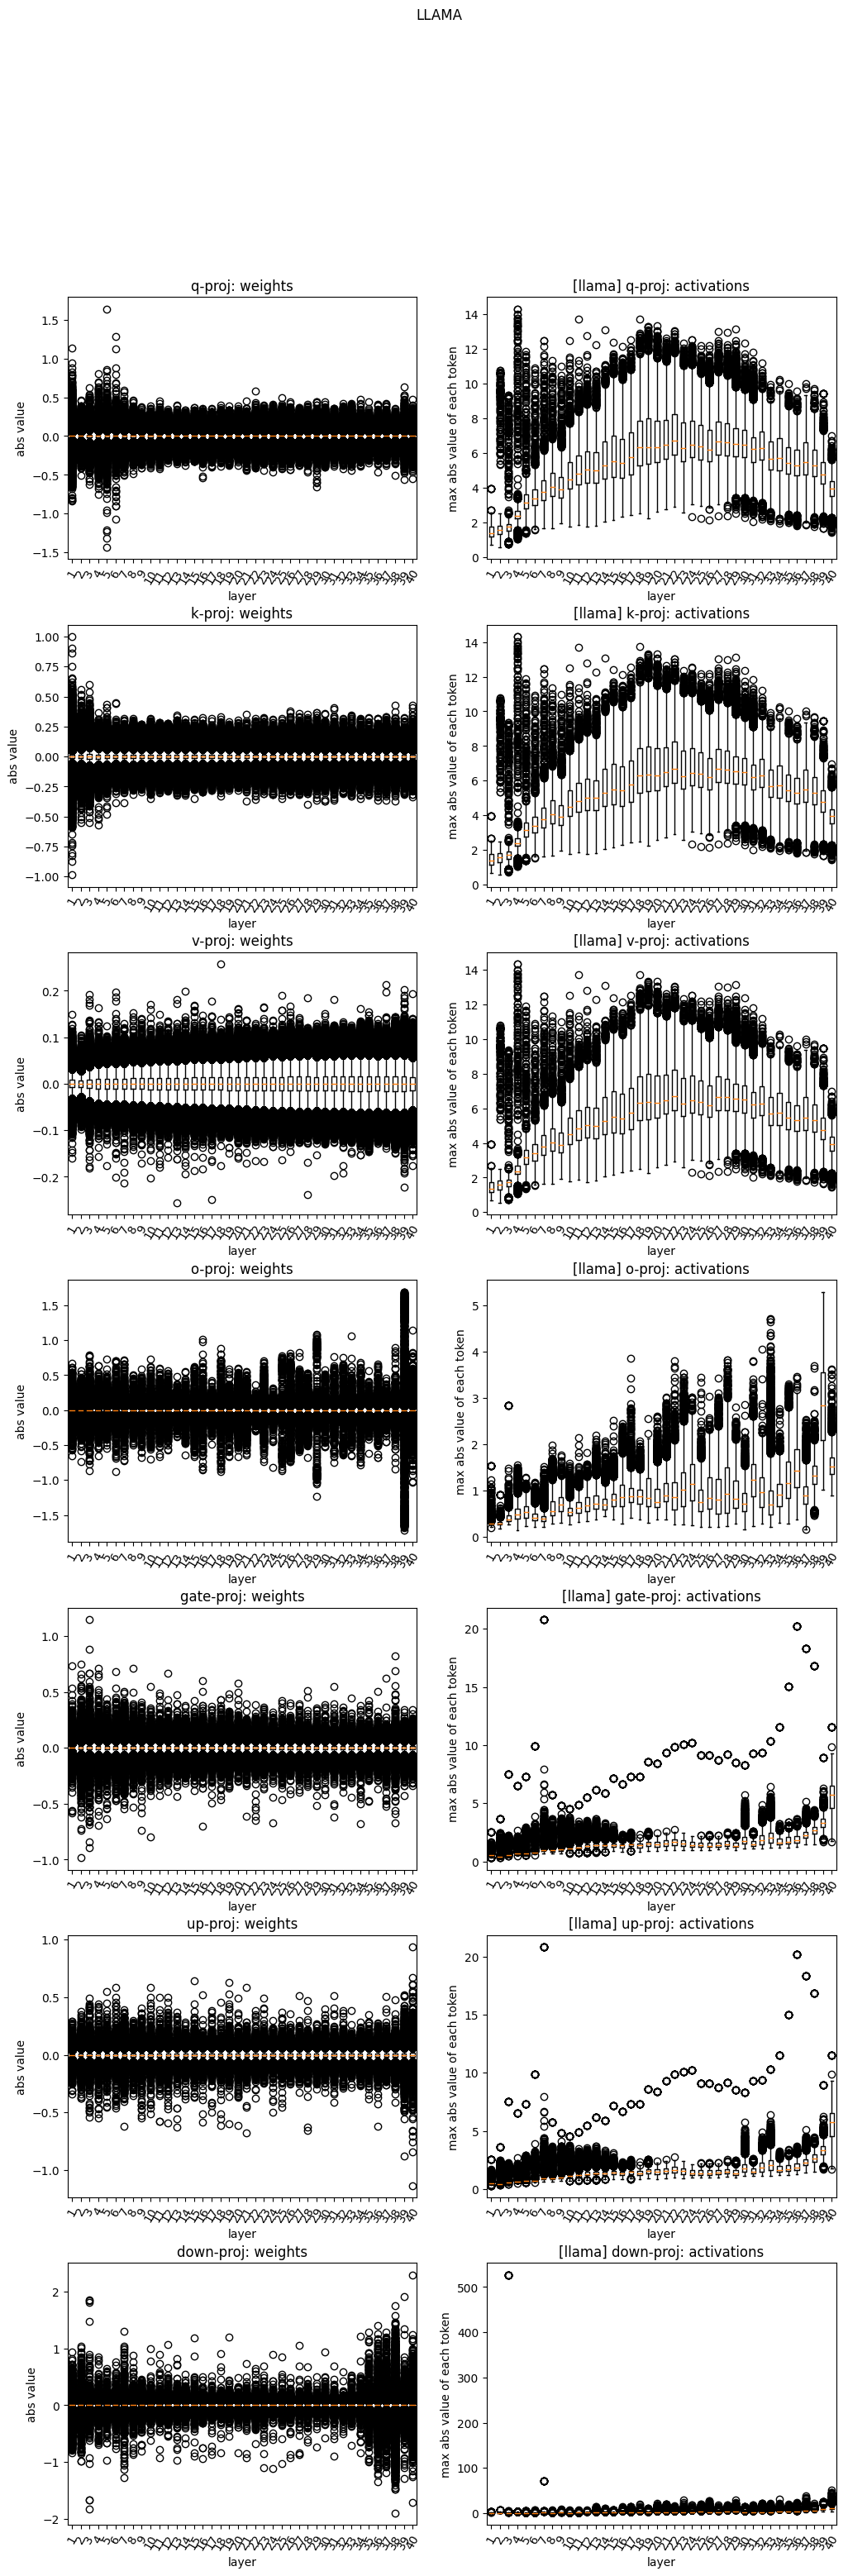

In [9]:
model_name = 'llama'
fig = plt.figure(figsize=(12, 35))
plt.subplots_adjust(hspace=0.25)
for i, component in enumerate([
    'q-proj.pt',
    'k-proj.pt',
    'v-proj.pt',
    'o-proj.pt',
    'gate-proj.pt',
    'up-proj.pt',
    'down-proj.pt',
]):
    print(f'{component}: weights')
    ax = plt.subplot2grid((7, 2), (i, 0))
    plot_weights(ax, model_name, component)
    print(f'{component}: activations')
    ax = plt.subplot2grid((7, 2), (i, 1))
    plot_activations(ax, model_name, component)
plt.suptitle('LLAMA')

Text(0.5, 0.98, 'LLAMA Activations before Layer Norm')

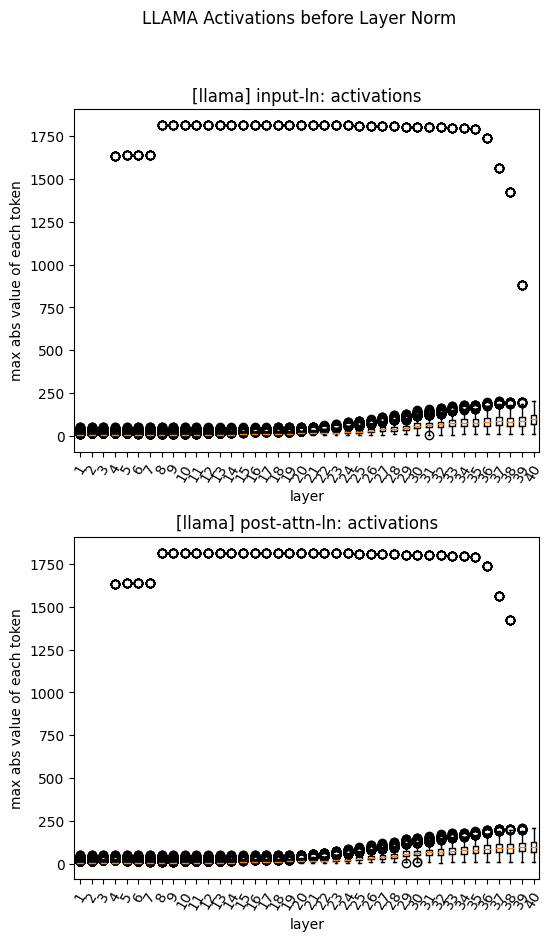

In [10]:
model = 'llama'
fig = plt.figure(figsize=(6, 10))
plt.subplots_adjust(hspace=0.25)
for i, component in enumerate([
    'input-ln.pt',
    'post-attn-ln.pt',
]):
    ax = plt.subplot2grid((2, 1), (i, 0))
    plot_activations(ax, model, component)
    # ax = plt.subplot2grid((2, 2), (i, 1))
    # plot_activations(ax, model, component, text_only=True)
plt.suptitle('LLAMA Activations before Layer Norm')

In [11]:
def plot_tensor(field: str, model_name: str, component: str):
    tensor = torch.load(f'{SNAPSHOT_PATH}/{field}/{model_name}/{component}')
    tensor = tensor[0].detach().squeeze(0).abs()
    tensor = tensor.cpu().numpy()

    print(tensor.shape)
    plt.clf()
    fig = plt.figure(figsize=(12, 4))
    ax = plt.subplot(121)
    sns.heatmap(tensor, ax=ax)
    ax.set_xlabel('channel')
    ax.set_ylabel('tokens')

    _x, _y = np.arange(tensor.shape[1]), np.arange(tensor.shape[0])
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()
    ax = plt.subplot(122, projection='3d')
    colors = np.tile(tensor.max(axis=0).reshape((1, -1)), (tensor.shape[0], 1)).flatten()
    colors = plt.cm.jet(colors / tensor.max())
    tensor = tensor.flatten()
    ax.bar3d(x, y, 0, 1, 1, tensor, color=colors, shade=False)

    ax.set_xlabel('channel')
    ax.set_ylabel('tokens')
    # ax.set_zlabel('value')

    name = component[:-3]
    layer = name.split('-')[0]
    plt.suptitle(model_name + ' ' + field + f' #{name}')
    os.makedirs(f'{SNAPSHOT_PATH}/img/llama-layer-{layer}', exist_ok=True)
    plt.savefig(f'{SNAPSHOT_PATH}/img/llama-layer-{layer}/{name}.png')

In [12]:
plot_tensor('activations/3045575', 'llama', '0-input-ln.pt')
plot_tensor('activations/3045575', 'llama', '0-q-proj.pt')
plot_tensor('activations/3045575', 'llama', '0-post-attn-ln.pt')
plot_tensor('activations/3045575', 'llama', '0-gate-proj.pt')

(586, 5120)


(586, 5120)
(586, 5120)
(586, 5120)


(67, 4096)
(67, 4096)
(67, 4096)
(67, 4096)


<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

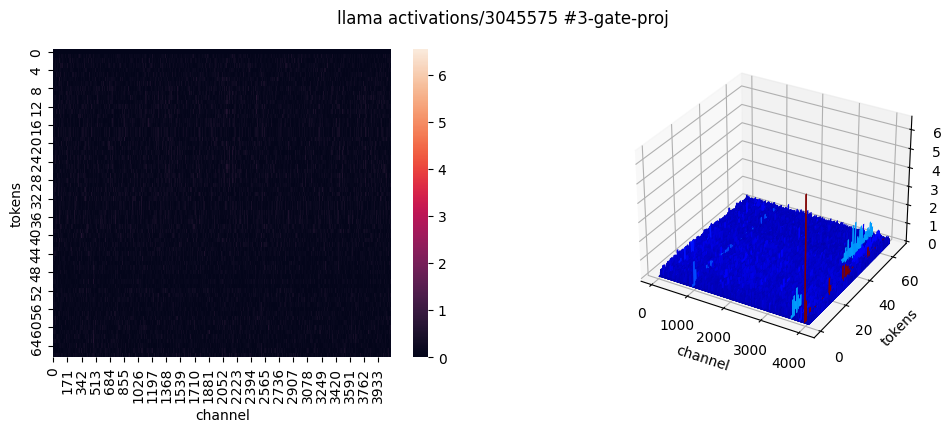

In [ ]:
plot_tensor('activations/3045575', 'llama', '3-input-ln.pt')
plot_tensor('activations/3045575', 'llama', '3-q-proj.pt')
plot_tensor('activations/3045575', 'llama', '3-post-attn-ln.pt')
plot_tensor('activations/3045575', 'llama', '3-gate-proj.pt')

(67, 4096)
(67, 4096)
(67, 4096)
(67, 4096)


<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

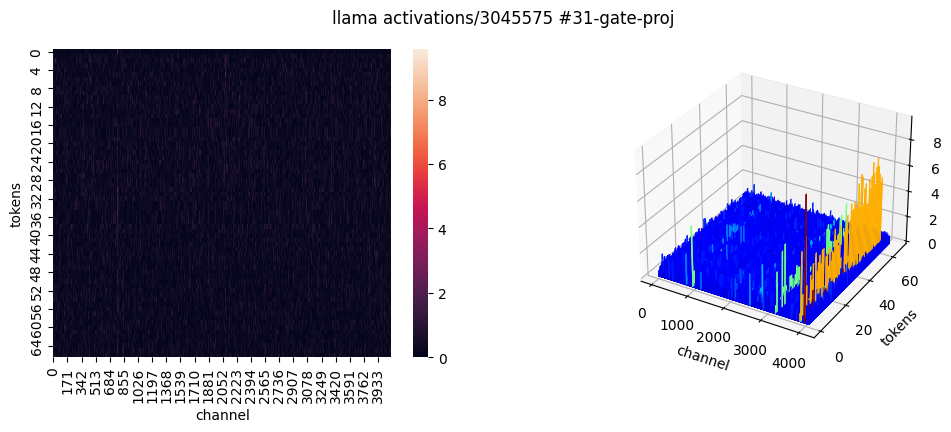

In [ ]:
plot_tensor('activations/3045575', 'llama', '31-input-ln.pt')
plot_tensor('activations/3045575', 'llama', '31-q-proj.pt')
plot_tensor('activations/3045575', 'llama', '31-post-attn-ln.pt')
plot_tensor('activations/3045575', 'llama', '31-gate-proj.pt')